In [2]:
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [3]:
from IPython.display import Markdown, HTML

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.impute import KNNImputer

In [7]:
from sklearn.linear_model import Ridge

In [8]:
import numpy as np

In [9]:
import matplotlib.pyplot as plt

In [10]:
import seaborn as sns

In [11]:
import geojson
import plotly.express as px
import plotly.graph_objects as go

# <p style = 'text-align:center'> Fonctions </p>

## Features engineering fonctions

In [12]:
def features_choices_15(bench,drop_list,names,info,model):
    bench["age"] = bench["DataYear"]-bench["YearBuilt"]
    bench = bench.drop(columns=drop_list)
    bench = bench.rename(names,axis='columns')
    bench['lat']=bench['loc'].apply(lambda r:r.split('\'')[3]).astype('float')
    bench['lon']=bench['loc'].apply(lambda r:r.split('\'')[7]).astype('float')
    bench['adress']=bench['loc'].apply(lambda r:r.split('\'')[11].split(',')[0].split("\"")[3])
    bench = bench.drop(columns=['loc'])
    bench_info = bench[info]
    bench_model = bench[model]
    return bench_info, bench_model

In [13]:
def features_choices_16(bench,drop_list,names,info,model):
    bench["age"] = bench["DataYear"]-bench["YearBuilt"]
    bench = bench.drop(columns=drop_list)
    bench = bench.rename(names,axis='columns')
    bench_info = bench[info]
    bench_model = bench[model]
    return bench_info, bench_model

In [14]:
def features_choices(bench15_1, bench16_1, to_drop_15, to_drop_16, new_names_15, new_names_16, info_var, model_var):
    bench15_info, bench15_model = features_choices_15(bench15_1, to_drop_15, new_names_15, info_var, model_var)
    bench16_info, bench16_model = features_choices_16(bench16_1, to_drop_16, new_names_16, info_var, model_var)
    bench_info = pd.concat([bench15_info, bench16_info],axis=0).reset_index(drop=True)
#     bench_info = bench_info.drop_duplicates(subset = ["id"]).reset_index(drop=True)
    bench_model = pd.concat([bench15_model, bench16_model],axis=0).reset_index(drop=True)
#     bench_model = bench_model.drop_duplicates(subset = ["id"]).reset_index(drop=True) 
    return bench_info, bench_model

In [15]:
def loc_outlier():
    # from sklearn.neighbors import LocalOutlierFactor
    # X = bench_model_cleaned[['age', 'nb', 'nf', 'building_gfa' ,'parking_gfa','total_gfa', 'lput_gfa', 'sput_gfa', 'tput_gfa', 'energy_use', 'ghg_emission']].values
    # clf = LocalOutlierFactor(n_neighbors=3)
    # a = pd.DataFrame(data=clf.fit_predict(X),columns=['outlier'])
    # a['id']=bench_model_cleaned.id
    # a.outlier.value_counts()
    # bench_model_cleaned = bench_model_cleaned.drop(bench_model_cleaned[bench_model_cleaned.id.isin(a[a['outlier']==-1]['id'].values)].index)
    # clf.negative_outlier_factor_
    return 3

## Linear model

In [16]:
def lin_fit(X,y):
    n, p = X.shape[0], X.shape[1]
    X_1 = np.concatenate((np.ones((n,1)),X),axis=1)
    beta = np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(X_1),X_1)),np.transpose(X_1)),y)
    return beta

def lin_predict(X,beta):
    n=X.shape[0]
    X_1 = np.concatenate((np.ones((n,1)),X),axis=1)
    y_pred = np.matmul(X_1,beta)
    return y_pred

## Cleaning function

In [42]:
def outlier_cleaning(bench,outliers_id):
    # Suppression des données non utilisables 
    drop_idx_1 = bench[(bench['energy_use'].isna())|(bench['ghg_emission'].isna())].index
    bench = bench.drop(drop_idx_1)
    bench_no_outlier = bench.drop(bench[bench['id'].isin(outliers_id)].index)
    #(bench_no_outlier['SiteEnergyUse(kBtu)']>=2*10**7)|
    outliers_idx = bench_no_outlier[(bench_no_outlier['energy_use']<=10**4)|(bench_no_outlier.energy_use > 25118864)|(bench_no_outlier.ghg_emission < 1)].index
    bench_no_outlier = bench_no_outlier.drop(outliers_idx)
    return bench_no_outlier

In [18]:
def property_use_types_cleansing_and_imputation(bench_model):
    # Imputation de la variable largest property use type avec la variable primary property type
    unchanged = ["Hotel","Retail Store","Non-Refrigerated Warehouse","Other","Distribution Center","Medical Office","Worship Facility","Laboratory","Refrigerated Warehouse","Supermarket/Grocery Store", "Restaurant", "College/University","Senior Care Community","Self-Storage Facility"]
    for idx in bench_model[(~bench_model["primary_type"].isna())&(bench_model["lput"].isna())].index:
        if (bench_model.loc[idx,"primary_type"]=="Large Office")|(bench_model.loc[idx,"primary_type"]=="Small- and Mid-Sized Office"):
            bench_model.at[idx,"lput"] = "Office"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]    
        if "Multifamily" in bench_model.loc[idx,"primary_type"]:
            bench_model.at[idx,"lput"] = "Multifamily Housing"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if (bench_model.loc[idx,"primary_type"]=="SPS-District K-12"):
            bench_model.at[idx,"lput"] = "K-12 School"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"] 
        if (bench_model.loc[idx,"primary_type"]=="Hospital"):
            bench_model.at[idx,"lput"] = "Hospital (General Medical & Surgical)"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if idx in [649, 2262, 2716]:
            bench_model.at[idx,"lput"] = "Retail Store"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if idx==347:
            bench_model.at[idx,"lput"] = "Medical Office"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if idx==309:
            bench_model.at[idx,"lput"] = "Other"
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]
        if bench_model.loc[idx,"primary_type"] in unchanged:
            bench_model.at[idx,"lput"] = bench_model.loc[idx,"primary_type"]
            bench_model.at[idx,"lput_gfa"] = bench_model.loc[idx,"building_gfa"]

    # Imputation des second et third property use type
    bench_model['sput'] = bench_model['sput'].fillna('Aucun')
    #
    bench_model['sput_gfa'] = bench_model['sput_gfa'].fillna(bench_model['sput_gfa'].mean())
    
    # Imputation de parking_gfa
    for idx in bench_model.index:
        if bench_model.loc[idx,'parking_gfa']==0:
            bench_model.at[idx,'parking_gfa'] = bench_model['parking_gfa'].mean()
    
    # Suppression des propriétés dont on ne connais pas le nombre d'étage
    drop_idx_2 = bench_model[(bench_model["nf"].isna())].index
    bench_model = bench_model.drop(drop_idx_2)
    # Regroupement de la classe NonResidential
    bench_model['type']=bench_model['type'].replace('Nonresidential COS','NonResidential')
    # Reset de l'index
    bench_model = bench_model.reset_index(drop=True)
    
    Xnum = bench_model[['age','nb','nf','building_gfa','parking_gfa','lput_gfa','sput_gfa','energy_score']].values
    Xcat = bench_model[['type','district_code','lput','sput']]
    enc = OneHotEncoder(handle_unknown='ignore')
    Xenc = enc.fit_transform(Xcat.values).toarray()
    X = np.concatenate((Xnum, Xenc),axis=1)
    imputer = KNNImputer(n_neighbors=2)
    X_imp = imputer.fit_transform(X)
    bench_model['energy_score'] = X_imp[:,7]
    
    return bench_model

## Data Visualisation Functions

In [19]:
def boxplot(x):
    fig, ax = plt.subplots(figsize=(15,15))
    ax.boxplot(x, vert = False)
    plt.show()

In [20]:
def barplot(x, y, data):
    fig, ax = plt.subplots(figsize=(15,15))
    sns.set_theme(style="whitegrid") 
    ax = sns.barplot(x=x, y=y, data=data)
    plt.show()

In [21]:
def seattle_map():
    f = open(r"C:\Users\Nabil\Desktop\Openclassrooms\Projet4\2016_seattle_city.geojson", "r")
    dep_gjs=geojson.load(f)
    scl = [[0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]]
    fig = px.choropleth(pd.DataFrame([[1,2],[1,2]],columns=['CD','color']), geojson=dep_gjs, color="color",locations="CD", featureidkey="properties.rowID",projection="mercator",color_continuous_scale=["#ffffff","#eeeeee"])
    fig.update_layout(coloraxis_showscale=False)
    fig.add_traces(go.Scattergeo(lat=bench_info.lat, lon=bench_info.lon, text=bench_model["id"].astype('str')+' : '+bench_model["energy_use"].astype('str'),marker = dict(size = 3,color = bench_model['energy_use'],colorscale = scl, colorbar = dict(titleside = "right", outlinecolor = "rgba(68, 68, 68, 0)"))))
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(margin={"r":0,"t":20,"l":0,"b":20})
    fig.show()

In [22]:
def histogram(data, x):
    fig, ax = plt.subplots(figsize=(15,15))
    sns.set_theme(style="whitegrid") 
    sns.histplot(data=data, x=x)
    plt.show()

In [23]:
def model_vs_real(y_pred, y_true, exp_variable):
#     if exp_variable == 'ghg_emission':
#         gap = 100
#     else:
#         gap = 2*10**6
    fig, ax = plt.subplots(figsize=(15,15))
    ax.scatter(y_pred, y_true, label = 'model vs real')
    ax.plot(y_true, y_true, linestyle = '--', color = 'r', label = 'perfect model')
#     ax.plot(y_true , y_true + gap, linestyle = '--', color = 'y', label = '+2x10^6')
#     ax.plot(y_true , y_true - gap, linestyle = '--', color = 'y', label = '-2x10^6')
    ax.set_xlabel("y_pred")
    ax.set_ylabel("y_true")
    ax.set_title('Model VS Real')
    ax.legend()
    plt.show()

# <p style = 'text-align:center'> Importation des données </p>

In [24]:
bench15_0, bench16_0 = pd.read_csv(r"2015-building-energy-benchmarking.csv"), pd.read_csv(r"2016-building-energy-benchmarking.csv")

In [25]:
outliers_id = np.concatenate((bench15_0[~bench15_0.Outlier.isna()].OSEBuildingID.values,bench16_0[~bench16_0.Outlier.isna()].OSEBuildingID.values))

# <p style = 'text-align:center'> Choix des features </p>

Dans cette section, nous allons choisir les variables les plus pertinentes à la résolution de la problématique. Pour cela on se base, entre autre sur les description des variables que l'on trouve dans les métadatas.

In [26]:
# Importation des métadata
import json
file=open(r"socrata_metadata_2015-building-energy-benchmarking.json")
meta_2015=json.load(file)
file_2=open(r"socrata_metadata_2016-building-energy-benchmarking.json")
meta_2016=json.load(file_2)

In [27]:
# Affichage des descriptions des variables
display(Markdown('# <p style=\'text-align:center\'> Description des variables : </p>'))
for i in range(len(meta_2015["columns"])):
    try:
        print('\033[1m' + meta_2015["columns"][i]["name"] + '\033[0m' + ' : ' + meta_2015["columns"][i]["description"]+'\n')
    except:
        continue

# <p style='text-align:center'> Description des variables : </p>

OSEBuildingID : A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.

BuildingType : City of Seattle building type classification.

PrimaryPropertyType : The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.

PropertyName : Official or common property name.

TaxParcelIdentificationNumber : 	
Property King County PIN

CouncilDistrictCode : Property City of Seattle council district.

YearBuilt : Year in which a property was constructed or underwent a complete renovation.

PropertyGFATotal : Total building and parking gross floor area.

PropertyGFAParking : Total space in square feet of all types of parking (Fully Enclosed, Partially Enclosed, and Open).

PropertyGFABuilding(s) : Total floor space in square feet between the outside surfaces of a buil

In [28]:
# features à supprimer dans le dataset de 2015 et celui de 2016
to_drop_15 = ["DataYear","YearBuilt",'TaxParcelIdentificationNumber', 'Neighborhood','ListOfAllPropertyUseTypes','YearsENERGYSTARCertified','SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'Electricity(kWh)',  'NaturalGas(therms)', 'OtherFuelUse(kBtu)','GHGEmissionsIntensity(kgCO2e/ft2)','DefaultData', 'Comment', 'ComplianceStatus', 'Outlier', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas','City Council Districts', 'SPD Beats']
to_drop_16 = ['DataYear', 'City', 'State', 'TaxParcelIdentificationNumber', 'Neighborhood', 'YearBuilt', 'ListOfAllPropertyUseTypes','YearsENERGYSTARCertified','SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)', 'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier', 'GHGEmissionsIntensity']

# nouveaux noms pour les features qu'on garde dans le dataset de 2015 et 2016 
new_names_15 = {'OSEBuildingID':'id', 'CouncilDistrictCode':'district_code' , 'BuildingType':'type', 'PrimaryPropertyType':'primary_type', 'PropertyName':'name','Location':'loc', 'NumberofBuildings':'nb', 'NumberofFloors':'nf','PropertyGFATotal':'total_gfa',  'PropertyGFAParking':'parking_gfa', 'PropertyGFABuilding(s)':'building_gfa', 'LargestPropertyUseType':'lput', 'LargestPropertyUseTypeGFA':'lput_gfa', 'SecondLargestPropertyUseType':'sput', 'SecondLargestPropertyUseTypeGFA':'sput_gfa', 'ThirdLargestPropertyUseType':'tput', 'ThirdLargestPropertyUseTypeGFA':'tput_gfa', 'ENERGYSTARScore':'energy_score', 'SiteEnergyUse(kBtu)':'energy_use', 'GHGEmissions(MetricTonsCO2e)':'ghg_emission', 'Zip Codes':'zip', 'SteamUse(kBtu)':'steam', 'Electricity(kBtu)':'electricity', 'NaturalGas(kBtu)':'natural_gas'}
new_names_16 = {'OSEBuildingID':'id', 'CouncilDistrictCode':'district_code' ,'BuildingType':'type', 'PrimaryPropertyType':'primary_type', 'PropertyName':'name', 'Address':'adress', 'ZipCode':'zip', 'Latitude':'lat', 'Longitude':'lon', 'NumberofBuildings':'nb', 'NumberofFloors':'nf', 'PropertyGFATotal':'total_gfa', 'PropertyGFAParking':'parking_gfa', 'PropertyGFABuilding(s)':'building_gfa', 'LargestPropertyUseType':'lput', 'LargestPropertyUseTypeGFA':'lput_gfa', 'SecondLargestPropertyUseType':'sput', 'SecondLargestPropertyUseTypeGFA':'sput_gfa', 'ThirdLargestPropertyUseType':'tput', 'ThirdLargestPropertyUseTypeGFA':'tput_gfa', 'ENERGYSTARScore':'energy_score', 'SiteEnergyUse(kBtu)':'energy_use', 'TotalGHGEmissions':'ghg_emission', 'SteamUse(kBtu)':'steam', 'Electricity(kBtu)':'electricity', 'NaturalGas(kBtu)':'natural_gas'}

In [29]:
# features pour le dataset des informations des propriétés
info_var = ['id', 'name', 'lat', 'lon', 'adress', 'energy_score', 'zip']

#features pour le dataset des variables du modèle
model_var = ['id', 'age', 'nb', 'nf', 'type', 'primary_type','district_code', 'building_gfa' ,'parking_gfa','total_gfa', 'lput', 'lput_gfa', 'sput', 'sput_gfa', 'tput', 'tput_gfa', 'energy_score', 'energy_use', 'ghg_emission','electricity','natural_gas','steam']

In [30]:
# choix des features et renommage
bench_info, bench_model = features_choices(bench15_0, bench16_0, to_drop_15, to_drop_16, new_names_15, new_names_16, info_var, model_var)

In [31]:
# Taux de complétion des features
completion_rate = (100*bench_model.describe().T[['count']]/bench_model.shape[0]).T
completion_rate.index=['comp_rate']
completion_rate

,id,age,nb,nf,district_code,building_gfa,parking_gfa,total_gfa,lput_gfa,sput_gfa,tput_gfa,energy_score,energy_use,ghg_emission,electricity,natural_gas,steam
comp_rate,100.0,100.0,99.880881,99.880881,100.0,100.0,100.0,100.0,97.677189,48.213222,17.212627,75.83383,99.776653,99.717094,99.717094,99.717094,99.717094


On ne garde pas la variable third property use type et la third property use type gfa. 

In [32]:
bench_model = bench_model.drop(columns=['tput','tput_gfa'])

# <p style = 'text-align:center'> Création de nouvelles features </p>

On crée de nouvelles features à partir des consomations des différentes sources d'énergie : des features correspondant à l'utilisation ou non de chaque source d'energie et à la proportion d'énergie utilisé par chaque source.

In [33]:
bench_model['electricity_bool'] = bench_model['electricity'].apply(lambda x : 1 if x!=0 else 0)
bench_model['electricity_pct'] = bench_model['electricity'].divide(bench_model['energy_use'])
bench_model['natural_gas_bool'] = bench_model['natural_gas'].apply(lambda x : 1 if x!=0 else 0)
bench_model['natural_gas_pct'] = bench_model['natural_gas'].divide(bench_model['energy_use'])
bench_model['steam_bool'] = bench_model['steam'].apply(lambda x : 1 if x!=0 else 0)
bench_model['steam_pct'] = bench_model['steam'].divide(bench_model['energy_use'])
bench_model = bench_model.drop(columns=['electricity','natural_gas','steam'])

# <p style = 'text-align:center'> Bâtiments non destinés à l'habitation </p>

Dans le cadre de l'objectif ville neutre en carbone en 2050, on s'intéresse essentiellement aux propriétés non résidentielles. Il faut donc trouver un moyen de filtrer le dataset sur ces seuls propriétés. On s'intéresse donc à la variable building type.

<AxesSubplot:xlabel='count', ylabel='type'>

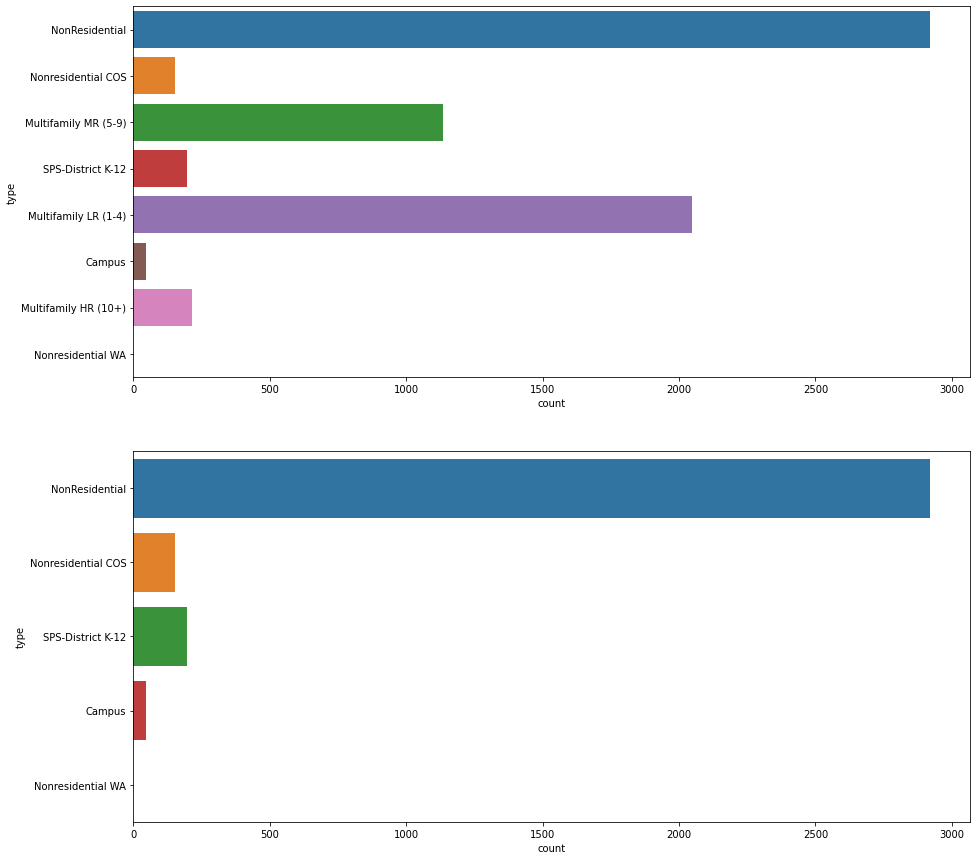

In [34]:
fig, ax = plt.subplots(2,1,figsize=(15,15))
sns.countplot(y=bench_model.type, ax=ax[0])
bench_model = bench_model.drop(bench_model[bench_model['type'].str.contains('Multifamily')].index)
sns.countplot(y=bench_model.type, ax=ax[1])

# <p style = 'text-align:center'> Nettoyage des outliers </p>

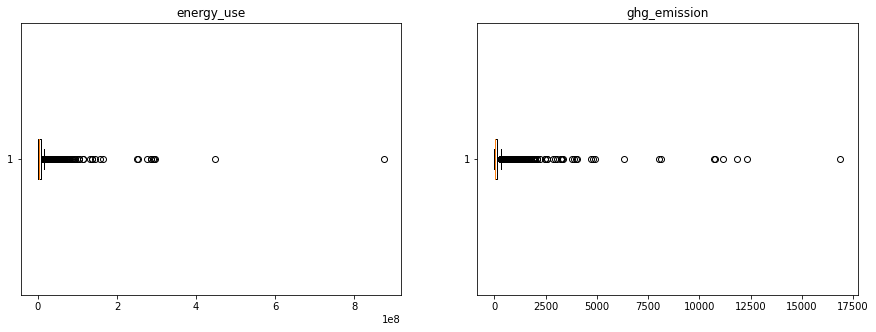

In [35]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].boxplot(bench_model[~bench_model['energy_use'].isna()]['energy_use'], vert = False)
ax[0].set_title('energy_use')
ax[1].boxplot(bench_model[~bench_model['ghg_emission'].isna()]['ghg_emission'], vert = False)
ax[1].set_title('ghg_emission')
plt.show()

In [43]:
# Suppression des outliers
bench_model = outlier_cleaning(bench_model,outliers_id)

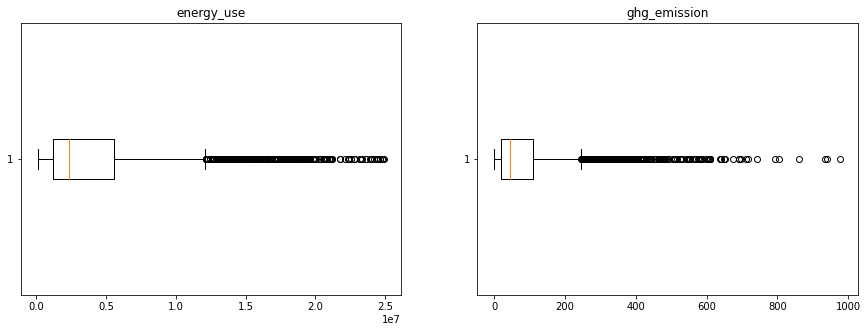

In [45]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].boxplot(bench_model['energy_use'], vert = False)
ax[0].set_title('energy_use')
ax[1].boxplot(bench_model['ghg_emission'], vert = False)
ax[1].set_title('ghg_emission')
plt.show()

# <p style = 'text-align:center'> Analyse de la variable district_code </p>

On s'intéresse à la variable district code. On veut savoir si elle présente un intérêt pour la modélisation de la consommation d'énergie et les émissions de GES. Pour cela, on trace la consommation moyenne en fonction du district code pour voir si le district impacte la consommation.

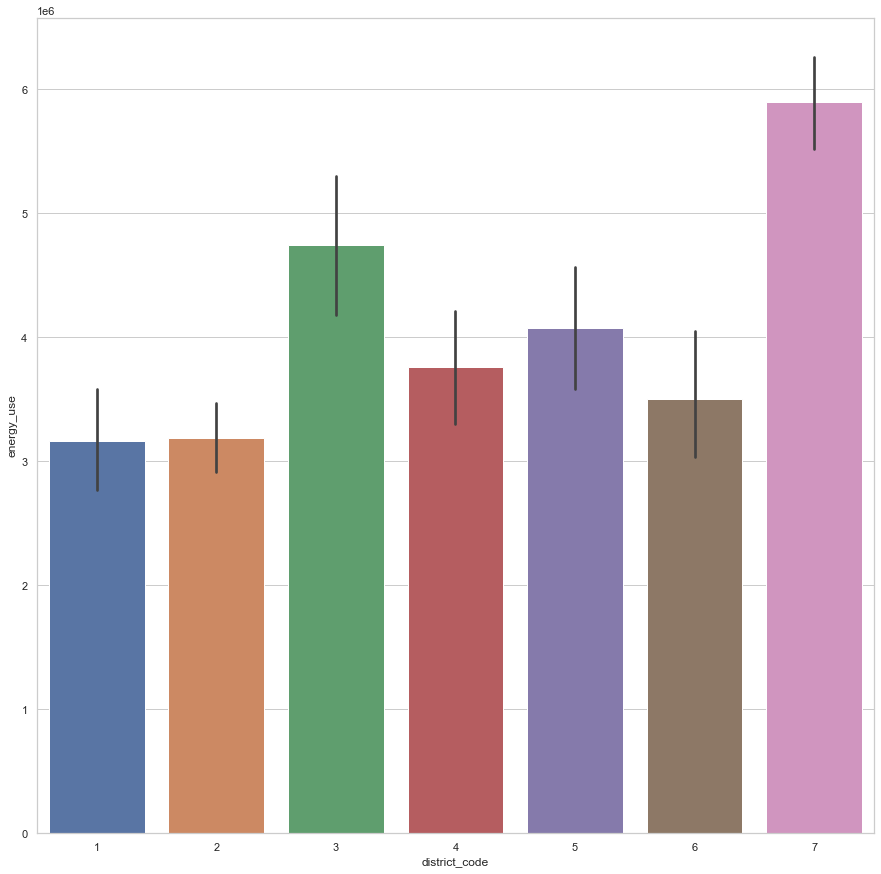

In [84]:
barplot("district_code","energy_use",bench_model)

# <p style = 'text-align:center'> Valeurs abbérentes </p>

On supprime les valeurs abbérentes qui peuvent tromper les modèles et dégrader les résultats

In [85]:
# Propriétés ayant des surfaces négatives 
negativ_area_index = bench_model[(bench_model["total_gfa"]<0)|(bench_model["building_gfa"]<0)|(bench_model["parking_gfa"]<0)].index
for idx in negativ_area_index:
    bench_model.at[idx,"building_gfa"] = np.abs(bench_model.at[idx,"building_gfa"])
    bench_model.at[idx,"parking_gfa"] = np.abs(bench_model.at[idx,"parking_gfa"])
    bench_model.at[idx,"total_gfa"] = np.abs(bench_model.at[idx,"total_gfa"])

In [86]:
# Valeurs abbérentes détectées manuellement
bench_model = bench_model.drop(bench_model[(bench_model.id.isin([33, 34, 54, 60, 61, 70, 85, 100, 102, 113, 230, 49784, 553]))].index)

# <p style = 'text-align:center'> Imputations </p>

In [49]:
bench_model_cleaned = property_use_types_cleansing_and_imputation(bench_model)

# <p style = 'text-align:center'> Exploration des features </p>

Extrait de la documentation de scikit learn :

“They (machine learning estimators) might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.”

C'est pour cette raison que nous appliquons le logarithme à nos features.

## Avant le log

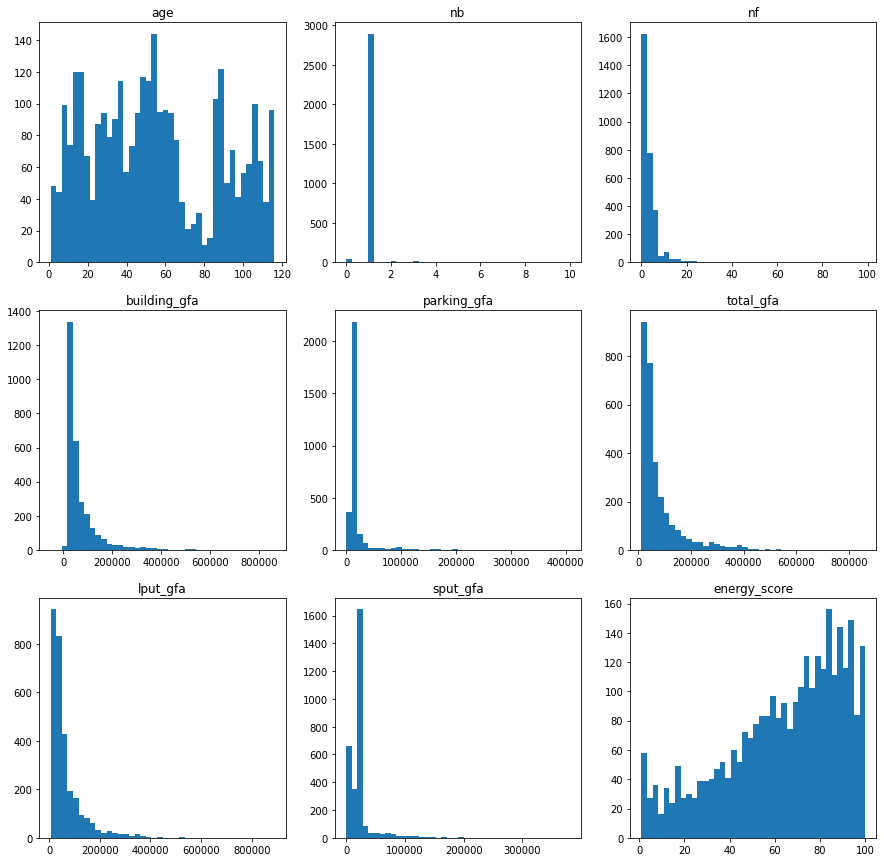

In [50]:
fig, axs = plt.subplots(3,3, figsize=(15,15))
numerical_features = ['age', 'nb', 'nf', 'building_gfa' ,'parking_gfa','total_gfa', 'lput_gfa', 'sput_gfa', 'energy_score']
for idx in range(len(numerical_features)):
    axs[idx//3,idx%3].hist(bench_model_cleaned[numerical_features[idx]],bins=40)
    axs[idx//3,idx%3].set_title(numerical_features[idx])

## Après le log

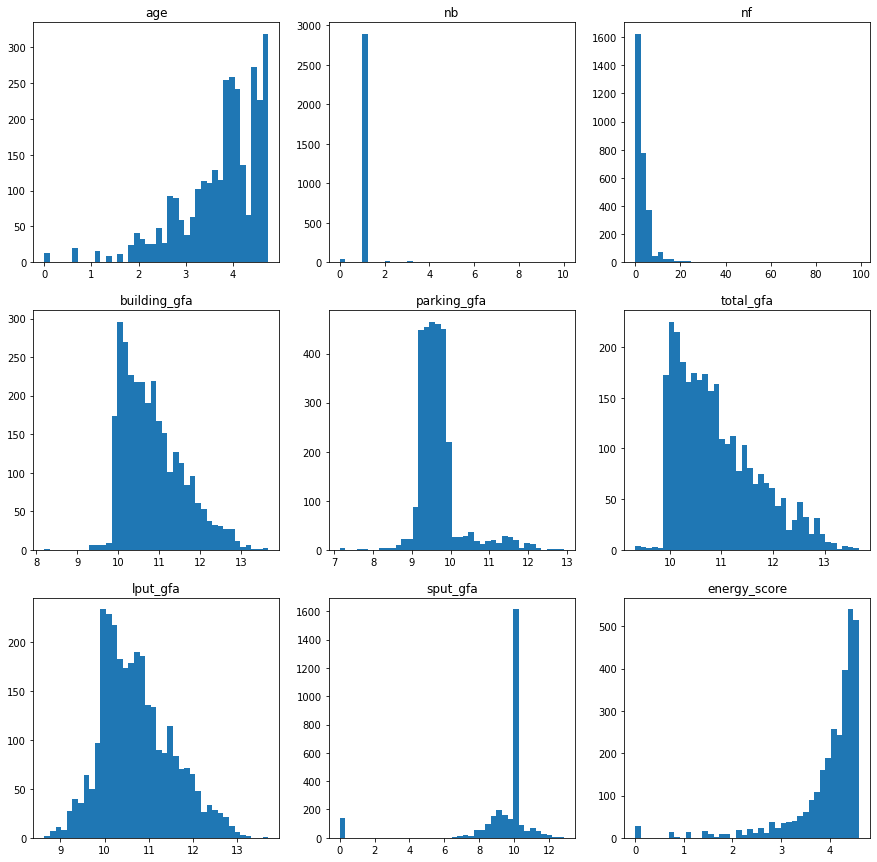

In [51]:
fig, axs = plt.subplots(3,3, figsize=(15,15))
numerical_features = ['age', 'nb', 'nf', 'building_gfa' ,'parking_gfa','total_gfa', 'lput_gfa', 'sput_gfa', 'energy_score']
for idx in range(len(numerical_features)):
    if (idx!=1)&(idx!=2):
        axs[idx//3,idx%3].hist(bench_model_cleaned[numerical_features[idx]].apply(lambda x: np.log(x) if x!=0 else 0),bins=40)
        axs[idx//3,idx%3].set_title(numerical_features[idx])
    else:
        axs[idx//3,idx%3].hist(bench_model_cleaned[numerical_features[idx]],bins=40)
        axs[idx//3,idx%3].set_title(numerical_features[idx])

##  Corrélations

On analyse les corrélations entre nos features numériques.

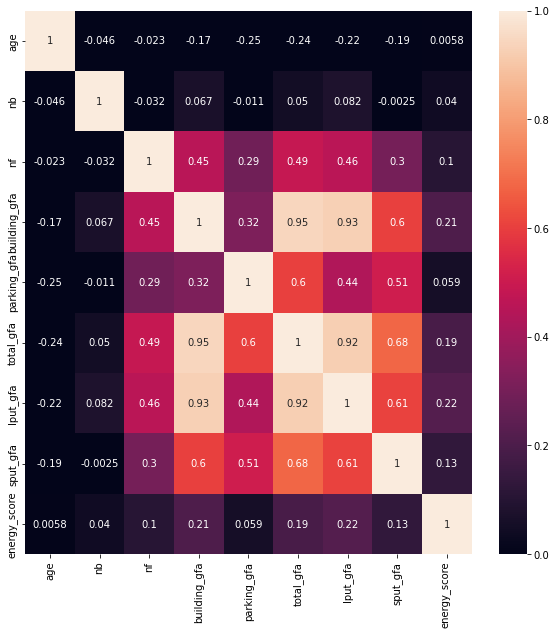

In [52]:
numerical_features = ['age', 'nb', 'nf', 'building_gfa' ,'parking_gfa','total_gfa', 'lput_gfa', 'sput_gfa', 'energy_score']
bench_model_num = bench_model_cleaned[numerical_features]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(bench_model_cleaned[numerical_features].corr(), annot=True, vmin=0, vmax=1)
plt.show()

La variable total_gfa est trop corrélée avec les variables lput_gfa et building_gfa. On choisit de ne pas l’utiliser

In [53]:
# boxplot(bench_model_cleaned['energy_use'])

In [54]:
# seattle_map()

# <p style = 'text-align:center'> Exploration des targets </p>

On analyse les corrélation entre nos deux targets, la consommation d'energie et les émissions de GES.

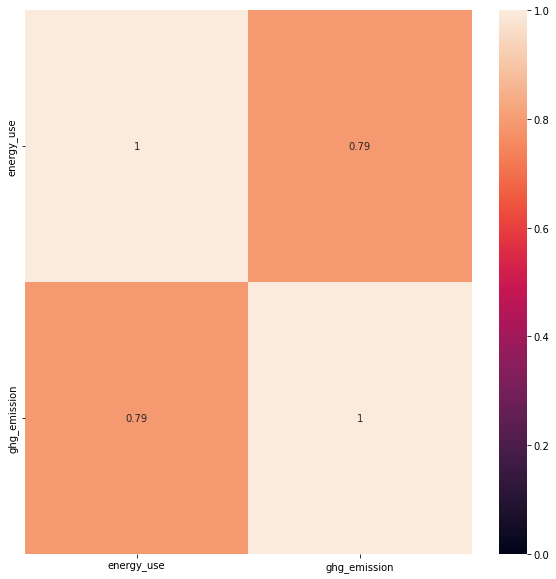

In [55]:
target = ['energy_use','ghg_emission']
bench_model_num = bench_model_cleaned[target]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(bench_model_cleaned[target].corr(), annot=True, vmin=0, vmax=1)
plt.show()

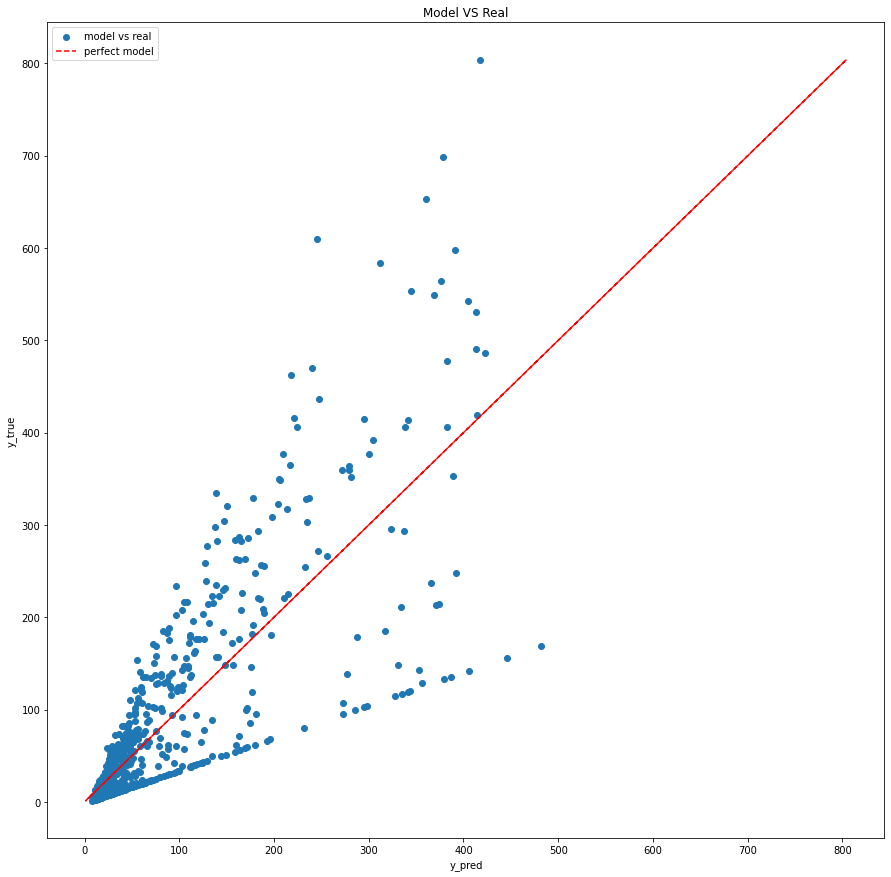

r2 :  0.6225958252669256


In [56]:
R = bench_model_cleaned.energy_use
s = bench_model_cleaned.ghg_emission
R_train, R_test, s_train, s_test = train_test_split(R, s, test_size=0.2, random_state=80)
scaler = StandardScaler()
scaler.fit([[x] for x in R_train])
R_train_std =scaler.transform([[x] for x in R_train])
R_test_std = scaler.transform([[x] for x in R_test])

beta = lin_fit(R_train_std,s_train)
s_pred_train_simple, s_pred_test_simple  = lin_predict(R_train_std,beta), lin_predict(R_test_std,beta)

model_vs_real(s_pred_test_simple, s_test, 'ghg_emission')
from sklearn.metrics import r2_score
print("r2 : ",r2_score(s_test,s_pred_test_simple))

## Sauvegarde du dataset clean

In [97]:
bench_model_cleaned.to_excel("benchmark_cleaned.xlsx", index=False)

In [340]:
# model_vs_real(s_pred_train_simple, s_train, 'ghg_emission')